Привет, меня зовут Люман Аблаев. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

### <font color='orange'>Общее впечатление</font>
* Этот проект выполнен довольно отлично.
* Молодец, что используешь классы и методы для более правильного и красивого написания кода.
* Выводы основанные на работе сформулированны логично и понятно.
* Ты получил высокое качество на тесте.
* Есть небольшие моменты, которые хотелось бы исправить или дополнить. Я думаю ты легко с этим справишься, и проект будет зачтен!
* Не забудь изменить выводы, если они того потребуют (если значения метрик изменятся)

### <font color='orange'>Общее впечатление[2]</font>
* Спасибо, что оперативно поправил все ошибки, и прислушился к советам!
* У тебя отличная работа, продолжай в том же духе.
* Твоя работа, принята. Удачи в следующих проектах!=)

<div class="alert alert-info">
Привет) Спасибо за ревью
    
</div>

# Отток клиентов

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Содержание 
* [Изучение файла](#open_file)
* [Подготовка данных](#prepare_data)
* [Исследование задачи](#research)
  * [Кодирование категоральных признаков](#research.categorical_features)
  * [Масштабирование количественных признаков](#research.numeric_features)
  * [Разделение данных на выборки](#research.split_data)
  * [Исследование моделей](#research.analyse_models)
    * [Дерево решений](#research.analyse_models.decision_tree)
    * [Случайный лес](#research.analyse_models.random_forest)
    * [Логистическая регрессия](#research.analyse_models.logistic_regression)
  * [Вывод](#research.conclusion)
* [Борьба с дисбалансом](#imbalances)
  * [Увеличение выборки](#imbalances.upsample)
    * [Дерево решений](#imbalances.upsample.decision_tree)
    * [Случайный лес](#imbalances.upsample.random_forest)
    * [Логистическая регрессия](#imbalances.upsample.logistic_regression)
  * [Уменьшение выборки](#imbalances.downsample)
    * [Дерево решений](#imbalances.downsample.decision_tree)
    * [Случайный лес](#imbalances.downsample.random_forest)
    * [Логистическая регрессия](#imbalances.downsample.logistic_regression)
  * [Взвешивание классов](#imbalances.class_weight)
    * [Дерево решений](#imbalances.class_weight.decision_tree)
    * [Случайный лес](#imbalances.class_weight.random_forest)
    * [Логистическая регрессия](#imbalances.class_weight.logistic_regression)
  * [Вывод](#imbalances.conclusion)
* [Тестирование модели](#test_model)

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

from collections import namedtuple 
from functools import partial

RANDOM_STATE = 12345

In [2]:
PredictionData = namedtuple('PredictionData', ('features_train', 'target_train', 'features_valid', 'target_valid'))

class PredictionAndTestData(object):
    __slots__ = (        
        'features_train', 
        'target_train', 
        'features_valid', 
        'target_valid',
        'features_test',
        'target_test',
    )
    
    def __init__(
        self, features_train, target_train, features_valid, 
        target_valid, features_test, target_test,
    ):
        self.features_train = features_train
        self.target_train = target_train 
        self.features_valid = features_valid
        self.target_valid = target_valid
        self.features_test = features_test
        self.target_test = target_test
        
    def __str__(self):
        return '\n'.join('размер {}: {}'.format(name, data.shape) for name, data in (
            ('features_train', self.features_train),
            ('target_train', self.target_train),
            ('features_valid', self.features_valid),
            ('target_valid', self.target_valid),
            ('features_test', self.features_test),
            ('target_test', self.target_test),
        ))
    
    def __iter__(self):
        return iter((
            self.features_train,
            self.target_train,
            self.features_valid,
            self.target_valid,
            self.features_test,
            self.target_test,
        ))

class ScorePredictorFactory(object):
    class ScorePredictor(object):
        def __init__(self, prediction_data, model_class):
            self._prediction_data = prediction_data
            self._model_class = model_class
            self._score = 0
            self._auc_roc_score = 0
            self._params = {}

        def predict_score(self, **params):
            model = self._model_class(random_state=RANDOM_STATE, **params)
            model.fit(self._prediction_data.features_train, self._prediction_data.target_train)
            predictions_valid = model.predict(self._prediction_data.features_valid)
            score = f1_score(self._prediction_data.target_valid, predictions_valid)  
            
            if score > self._score: 
                self._score = score
                self._params = params
                self._auc_roc_score = get_auc_roc_score(model, features_valid, target_valid)
            
            return score
        
        @property
        def score(self):
            return self._score
    
        @property
        def params(self):
            return self._params
        
        @property
        def auc_roc_score(self):
            return self._auc_roc_score
    
        def __str__(self):
            return 'Лучшее значение F1-меры: {} при параметрах {}\nЗначение AUC-ROC: {}'.format(
                self.score, self.params, self.auc_roc_score,
            )
    
    def __init__(self, features_train, target_train, features_valid, target_valid):
        self._prediction_data = PredictionData(features_train, target_train, features_valid, target_valid)
        
    def new_predictor(self, model_class):
        return self.ScorePredictor(self._prediction_data, model_class)
    

In [3]:
def analyze_df(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(10))
    display(df.describe())
    df.info()

def rows_ratio_for_dfs(first_df, second_df):
    return first_df.shape[0] / second_df.shape[0]

def scale(features_train, features_valid, numeric): 
    scaler = StandardScaler()
    numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

    scaler.fit(df[numeric])

    return scaler.transform(df[numeric])

def split_df(df, balance_func=None):
    # Выделим фичи и целевой показатель `Exited` 
    features = df.drop(columns=['Exited'])
    target = df['Exited']
    
    # Спрятанной тестовой выборки нет. 
    # Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. 
    # Размеры тестового и валидационного наборов обычно равны. 
    # Исходные данные разбивают в соотношении 3:1:1
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=RANDOM_STATE)
    features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=RANDOM_STATE)
    
    # Проведем масштабирование количественных признаков
    scaler = StandardScaler()
    numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
    
    scaler.fit(features_train[numeric])

    features_train = features_train.copy()
    features_train[numeric] = scaler.transform(features_train[numeric])

    features_valid = features_valid.copy()
    features_valid[numeric] = scaler.transform(features_valid[numeric])

    features_test = features_test.copy()
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    # Применим функцию samplefunc, чтобы сбалансировать классы
    if balance_func:
        features_train, target_train = balance_func(features_train, target_train)
    
    data = PredictionAndTestData(
        features_train,
        target_train,
        features_valid,
        target_valid, 
        features_test,
        target_test,
    )
    
    print(data)
        
    return data

def plot_classes_disbalance(df, title):
    df.value_counts(normalize=True).plot(kind='bar', title=title)
    plt.show()
    

def get_auc_roc_score(model, features_valid, target_valid):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    return roc_auc_score(target_valid, probabilities_one_valid)

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что ты владеешь знаниями о классах и их методах, и умеешь корректно их применять!
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Хорошо было бы разделять такие большие ячейки на логические группы: <br>
    1) Импорты в одну ячейку <br>
    2) Классы в отдельную <br>
    3) вспомогательные методы в другую <br>
    и т.п.
</div>

<div class="alert alert-info">
Разделил код на логические ячейки
    
</div>

<a name="open_file"></a>
## Изучение файла

**Описание данных**:
- *RowNumber* — индекс строки в данных
- *CustomerId* — уникальный идентификатор клиента
- *Surname* — фамилия
- *CreditScore* — кредитный рейтинг
- *Geography* — страна проживания
- *Gender* — пол
- *Age* — возраст
- *Tenure* — количество недвижимости у клиента
- *Balance* — баланс на счёте
- *NumOfProducts* — количество продуктов банка, используемых клиентом
- *HasCrCard* — наличие кредитной карты
- *IsActiveMember* — активность клиента
- *EstimatedSalary* — предполагаемая зарплата

In [4]:
churn_df = pd.read_csv('/datasets/Churn.csv')
analyze_df(churn_df)

Количество стобцов: 14
Количество строк: 10000


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Выводы**:
* столбцы `RowNumber`, `Surname` не нужны для обучения модели, от них можно избавиться
* в случае, если в столбце `CustomerId` находятся уникальные данные, то можно сделать этот столбец индексом 
* надо заполнить пропуски в `Tenure`, например заменив их на медиану, а затем поменять тип на *int*
* целевой признак - `Exited`

<div class="alert alert-block alert-success">
<b>Успех:</b> С выводом и планом действий согласен.
</div>

<a name="prepare_data"></a>
## Подготовка данных

Избавимся от столбцов `RowNumber` и `Surname`

In [5]:
churn_df = churn_df.drop(columns=['RowNumber', 'Surname'])

Посмотрим сколько в датасете уникальных значений `CustomerId`

In [6]:
print(churn_df['CustomerId'].unique().shape[0])
print(churn_df['CustomerId'].unique().shape[0] == churn_df.shape[0])

10000
True


Все значения уникальные, значит можно установить `CustomerId` в качестве индекса

In [7]:
churn_df = churn_df.set_index('CustomerId')

Заменим пропуски в столбце `Tenure` медианным значенем 

In [8]:
churn_df['Tenure'] = churn_df['Tenure'].fillna(churn_df['Tenure'].mean())

Приведем значения в столбце `Tenure` к типу *int*

In [9]:
churn_df['Tenure'] = churn_df['Tenure'].astype('int')

Выведем общую информацию о датасете

In [10]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15634602 to 15628319
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


<div class="alert alert-block alert-success">
<b>Успех:</b> Загрузка и подготовка данных выполнена корректно, все необходимые методы использованы.
</div>

<a name="research"></a>
## Исследование задачи

<a name="research.categorical_features"></a>
### Кодирование категоральных признаков

Закодируем категоральные признаки `Geography` и `Gender` при помощи метода OHE

In [11]:
churn_df = pd.get_dummies(churn_df, columns=['Geography', 'Gender'], drop_first=True)
churn_df.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
CustomerId,,,,,,,,,,,,
15634602,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
15647311,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
15619304,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
15701354,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
15737888,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
15574012,645,44,8,113755.78,2,1,0,149756.71,1,0,1,1
15592531,822,50,7,0.00,2,1,1,10062.80,0,0,0,1
15656148,376,29,4,115046.74,4,1,0,119346.88,1,1,0,0
15792365,501,44,4,142051.07,2,0,1,74940.50,0,0,0,1


<a name="research.numeric_features"></a>
### Масштабирование количественных признаков

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Тут небольшая ошибка, не совсем корректно масштабировать признаки на всем датасете, а потом разбивать на трейн и тест. В этом случае возможна <a href="https://machinelearningmastery.com/data-preparation-without-data-leakage/"> утечка данных. </a> <br> Scaler нужно стараться fit-ить только на трейне.
</div>

<div class="alert alert-info">
Добавил fit на трейне в метод <i>split_df</i>
    
</div>

<a name="research.split_data"></a>
### Разделение данных на выборки

Разделим данные на выборки

In [12]:
features_train, target_train, features_valid, target_valid, features_test, target_test = split_df(churn_df)

размер features_train: (6000, 11)
размер target_train: (6000,)
размер features_valid: (2000, 11)
размер target_valid: (2000,)
размер features_test: (2000, 11)
размер target_test: (2000,)


<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение данных на выборки выполнена корректно.
</div>


<div class="alert alert-block alert-info">
<b>Совет: </b> Хорошим тонном является, выводить размеры выборок. Это иногажда может предовтратить ошибки.
</div>


<div class="alert alert-info">
Добавил вывод рамеров выборок
    
</div>

Проверим дисбаланс классов

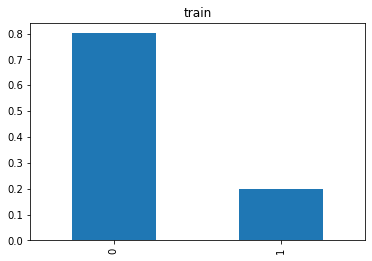

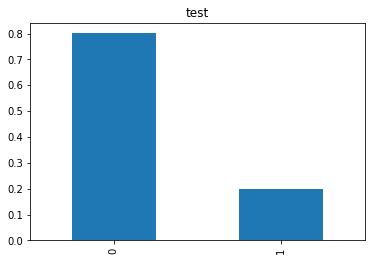

In [13]:
plot_classes_disbalance(target_train, 'train')
plot_classes_disbalance(target_train, 'test')

**Вывод**: классы несбалансированы: 80% отрицательных и 20% положительных

<a name="research.analyse_models"></a>
### Исследование моделей

In [14]:
churn_score_predictor_factory = ScorePredictorFactory(features_train, target_train, features_valid, target_valid)

<a name="research.analyse_models.decision_tree"></a>
#### Дерево решений 

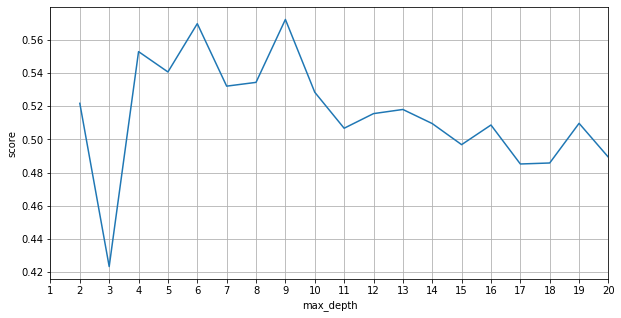

Лучшее значение F1-меры: 0.5722300140252455 при параметрах {'max_depth': 9}
Значение AUC-ROC: 0.78270041556022


In [15]:
decision_tree_predictor = churn_score_predictor_factory.new_predictor(DecisionTreeClassifier)
decision_tree_data = []

for max_depth in range(2, 21, 1):
    score = decision_tree_predictor.predict_score(max_depth=max_depth)
    decision_tree_data.append((max_depth, score))

pd.DataFrame(decision_tree_data).plot(x=0, y=1, grid=True, legend=False, xticks=range(1, 21), figsize=(10, 5)).set(xlabel='max_depth', ylabel = 'score')
plt.show()
print(decision_tree_predictor)

**Вывод**: Наилучшее значение F1-меры наблюдаем при значении `max_depth` = 9, после `max_depth` = 10 наблюдается переобучение.

<a name="research.analyse_models.random_forest"></a>
#### Случайный лес

In [16]:
random_forest_predictor = churn_score_predictor_factory.new_predictor(RandomForestClassifier)

for max_depth in range(2, 11, 1):
    for estim in range(10, 51, 10):
        random_forest_predictor.predict_score(n_estimators=estim, max_depth=max_depth)

print(random_forest_predictor)

Лучшее значение F1-меры: 0.5893129770992367 при параметрах {'n_estimators': 10, 'max_depth': 10}
Значение AUC-ROC: 0.8490955365082054


**Вывод**: модель случайного леса показывает лучшее значение F1-меры, чем дерево решений. 

<a name="research.analyse_models.logistic_regression"></a>
#### Логистическая регрессия

In [17]:
logistic_regression_predictor = churn_score_predictor_factory.new_predictor(LogisticRegression)

for solver in ('newton-cg', 'lbfgs', 'liblinear'):
    score = logistic_regression_predictor.predict_score(solver=solver)
    print('solver {} : {}'.format(solver, score))
    
print(logistic_regression_predictor)

solver newton-cg : 0.33389544688026984
solver lbfgs : 0.33389544688026984
solver liblinear : 0.33389544688026984
Лучшее значение F1-меры: 0.33389544688026984 при параметрах {'solver': 'newton-cg'}
Значение AUC-ROC: 0.7588011662301369


**Вывод**: модель логистической регрессии показывает худшее значение F1-меры, чем дерево решений или случайный лес 

<a name="research.conclusion"></a>
### Вывод

Наилучшее значение F1-меры 0.59 наблюдаем у модели случайного леса при значении гиперпараметров `n_estimators` = 10 и `max_depth` = 10. Посмотрим можно ли улучшить это значение если принять во внимание дисбаланс классов

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Шаг выполнен хорошо, однако хорошо было бы для моделей, посчитать AUC значения, для ROC кривой. <br> Сделай это пожалуйста и на следующем шаге.
</div>

<div class="alert alert-info">
Добавил вывод AUC-ROC в класс <b>ScorePredictor</b>
    
</div>

<a name="imbalances"></a>
## Борьба с дисбалансом

<a name="imbalances.upsample"></a>
### Увеличение выборки

Чтобы сбалансировать классы увеличим число объектов меньшего класса путём их многократного копирования.

In [18]:
def upsample(features, target, repeat):     
    features_zeros = features[target == 0]     
    features_ones = features[target == 1]     
    target_zeros = target[target == 0]     
    target_ones = target[target == 1] 

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)     
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)     
    
    features_upsampled, target_upsampled = shuffle(         
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)          
    
    return features_upsampled, target_upsampled

Поскольку у нас в выборке значения имели соотношение 80% к 20%, то параметру `repeat` зададим значение 4 

In [19]:
features_train, target_train, features_valid, target_valid, features_test, target_test = split_df(churn_df, partial(upsample, repeat=4))

размер features_train: (9588, 11)
размер target_train: (9588,)
размер features_valid: (2000, 11)
размер target_valid: (2000,)
размер features_test: (2000, 11)
размер target_test: (2000,)


Проверим, что выровняли дисбаланс классов

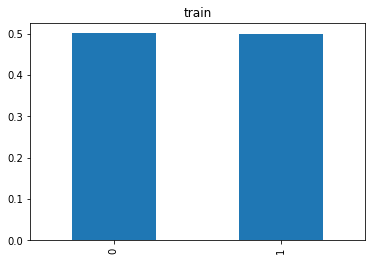

(9588,)

In [20]:
plot_classes_disbalance(target_train, 'train')
target_train.shape

In [21]:
churn_score_predictor_factory = ScorePredictorFactory(features_train, target_train, features_valid, target_valid)

<a name="imbalances.upsample.decision_tree"></a>
#### Дерево решений 

In [22]:
decision_tree_predictor = churn_score_predictor_factory.new_predictor(DecisionTreeClassifier)

for max_depth in range(2, 21, 1):
    score = decision_tree_predictor.predict_score(max_depth=max_depth)

print(decision_tree_predictor)

Лучшее значение F1-меры: 0.5963791267305644 при параметрах {'max_depth': 5}
Значение AUC-ROC: 0.8310244134068074


**Вывод**: Наилучшее значение F1-меры 0.60 наблюдаем при значении `max_depth` = 5, это значение выше, чем для несбалансированных классов

<a name="imbalances.upsample.random_forest"></a>
#### Случайный лес

In [23]:
random_forest_predictor = churn_score_predictor_factory.new_predictor(RandomForestClassifier)

for max_depth in range(2, 11, 1):
    for estim in range(10, 51, 10):
        random_forest_predictor.predict_score(n_estimators=estim, max_depth=max_depth)

print(random_forest_predictor)

Лучшее значение F1-меры: 0.6244635193133048 при параметрах {'n_estimators': 30, 'max_depth': 9}
Значение AUC-ROC: 0.8515929808430973


**Вывод**: Наилучшее значение F1-меры 0.63 наблюдаем при значении `max_depth` = 9  и `n_estimators` = 30, это значение выше, чем для несбалансированных классов 

<a name="imbalances.upsample.logistic_regression"></a>
#### Логистическая регрессия

In [24]:
logistic_regression_predictor = churn_score_predictor_factory.new_predictor(LogisticRegression)

for solver in ('newton-cg', 'lbfgs', 'liblinear'):
    score = logistic_regression_predictor.predict_score(solver=solver)
    
print(logistic_regression_predictor)

Лучшее значение F1-меры: 0.48843187660668386 при параметрах {'solver': 'newton-cg'}
Значение AUC-ROC: 0.7636024897319726


**Вывод**: Наилучшее значение F1-меры для линейной регрессии улучшилось сильно по сравенения со случаем дисбаланса классов, но оно все равно хуже, чем у остальных моделей 

<a name="imbalances.downsample"></a>
### Уменьшение выборки

Чтобы сбалансировать классы уменьшим число объектов большего класса путём их случайного удаления.

In [25]:
def downsample(features, target, fraction):     
    features_zeros = features[target == 0]     
    features_ones = features[target == 1]     
    target_zeros = target[target == 0]     
    target_ones = target[target == 1]      
    
    features_downsampled = pd.concat(         
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones])     
    
    target_downsampled = pd.concat(         
        [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [target_ones])          
    
    features_downsampled, target_downsampled = shuffle(         
        features_downsampled, target_downsampled, random_state=RANDOM_STATE)          
    
    return features_downsampled, target_downsampled

In [26]:
features_train, target_train, features_valid, target_valid, features_test, target_test = split_df(churn_df, partial(downsample, fraction=0.25))

размер features_train: (2397, 11)
размер target_train: (2397,)
размер features_valid: (2000, 11)
размер target_valid: (2000,)
размер features_test: (2000, 11)
размер target_test: (2000,)


Проверим, что выровняли дисбаланс классов

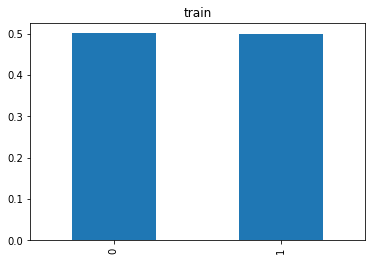

(2397,)

In [27]:
plot_classes_disbalance(target_train, 'train')
target_train.shape

In [28]:
churn_score_predictor_factory = ScorePredictorFactory(features_train, target_train, features_valid, target_valid)

<a name="imbalances.downsample.decision_tree"></a>
#### Дерево решений 

In [29]:
decision_tree_predictor = churn_score_predictor_factory.new_predictor(DecisionTreeClassifier)

for max_depth in range(2, 21, 1):
    score = decision_tree_predictor.predict_score(max_depth=max_depth)

print(decision_tree_predictor)

Лучшее значение F1-меры: 0.5943204868154158 при параметрах {'max_depth': 5}
Значение AUC-ROC: 0.8241029464247908


<a name="imbalances.downsample.random_forest"></a>
#### Случайный лес

In [30]:
random_forest_predictor = churn_score_predictor_factory.new_predictor(RandomForestClassifier)

for max_depth in range(2, 11, 1):
    for estim in range(10, 51, 10):
        random_forest_predictor.predict_score(n_estimators=estim, max_depth=max_depth)

print(random_forest_predictor)

Лучшее значение F1-меры: 0.6092184368737475 при параметрах {'n_estimators': 10, 'max_depth': 4}
Значение AUC-ROC: 0.8354975834598564


**Вывод**: Наилучшее значение F1-меры 0.61, что ниже, чем при upsampling

<a name="imbalances.downsample.logistic_regression"></a>
#### Логистическая регрессия

In [31]:
logistic_regression_predictor = churn_score_predictor_factory.new_predictor(LogisticRegression)

for solver in ('newton-cg', 'lbfgs', 'liblinear'):
    score = logistic_regression_predictor.predict_score(solver=solver)
    
print(logistic_regression_predictor)

Лучшее значение F1-меры: 0.48578811369509034 при параметрах {'solver': 'newton-cg'}
Значение AUC-ROC: 0.7623186082664425


<a name="imbalances.class_weight"></a>
### Взвешивание классов

Придадим больший вес объектам редкого класса 1 используя гиперпараметр `class_weight` = 'balanced'.

In [32]:
features_train, target_train, features_valid, target_valid, features_test, target_test = split_df(churn_df)
churn_score_predictor_factory = ScorePredictorFactory(features_train, target_train, features_valid, target_valid)

размер features_train: (6000, 11)
размер target_train: (6000,)
размер features_valid: (2000, 11)
размер target_valid: (2000,)
размер features_test: (2000, 11)
размер target_test: (2000,)


<a name="imbalances.class_weight.decision_tree"></a>
#### Дерево решений 

In [33]:
decision_tree_predictor = churn_score_predictor_factory.new_predictor(DecisionTreeClassifier)

for max_depth in range(2, 21, 1):
    score = decision_tree_predictor.predict_score(max_depth=max_depth, class_weight='balanced')

print(decision_tree_predictor)

Лучшее значение F1-меры: 0.5963791267305644 при параметрах {'max_depth': 5, 'class_weight': 'balanced'}
Значение AUC-ROC: 0.8310244134068074


**Вывод**: При гиперпараметрах `{'max_depth': 5, 'class_weight': 'balanced'}` наблюдаем наилучшее значение F1-меры 0.60 для  дерева решений

<a name="imbalances.class_weight.random_forest"></a>
#### Случайный лес

In [34]:
random_forest_predictor = churn_score_predictor_factory.new_predictor(RandomForestClassifier)

for max_depth in range(2, 11, 1):
    for estim in range(10, 51, 10):
        random_forest_predictor.predict_score(n_estimators=estim, max_depth=max_depth, class_weight='balanced')

print(random_forest_predictor)

Лучшее значение F1-меры: 0.6319526627218934 при параметрах {'n_estimators': 40, 'max_depth': 10, 'class_weight': 'balanced'}
Значение AUC-ROC: 0.851251217343439


**Вывод**: При гиперпараметрах `{'n_estimators': 40, 'max_depth': 9, 'class_weight': 'balanced'}` наблюдаем наилучшее значение F1-меры 0.63 для случайного леса 

<a name="imbalances.class_weight.logistic_regression"></a>
#### Логистическая регрессия

In [35]:
logistic_regression_predictor = churn_score_predictor_factory.new_predictor(LogisticRegression)

for solver in ('newton-cg', 'lbfgs', 'liblinear'):
    score = logistic_regression_predictor.predict_score(solver=solver, class_weight='balanced')
    
print(logistic_regression_predictor)

Лучшее значение F1-меры: 0.48843187660668386 при параметрах {'solver': 'newton-cg', 'class_weight': 'balanced'}
Значение AUC-ROC: 0.7636629788469564


**Вывод**: При гиперпараметрах `{'solver': 'newton-cg', 'class_weight': 'balanced'}` наблюдаем наилучшее значение F1-меры 0.49 для логистической регрессии 

<a name="imbalances.conclusion"></a>
### Вывод

Лучшим методом борьбы с дисбалансом классов оказалось взвешивание классов, т.е. выставление большего веса меньшему классу.  
А самая лучшая модель - случайный лес с гиперпараметрами `{'n_estimators': 40, 'max_depth': 9, 'class_weight': 'balanced'}`.   
Теперь осталось протестировать модель 

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, все нужные практики для борьбы с дисбалансом были использованы корректно, выводы логичны.
</div>

<a name="test_model"></a>
## Тестирование модели

Протестируем модель на тестовой выборке:

In [36]:
features_train, target_train, features_valid, target_valid, features_test, target_test = split_df(churn_df)

model = RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', random_state=RANDOM_STATE)
model.fit(features_train, target_train)

predictions_valid = model.predict(features_valid)
print('F1-score valid:', f1_score(target_valid, predictions_valid))

predictions_test = model.predict(features_test)
print('F1-score test:', f1_score(target_test, predictions_test))

размер features_train: (6000, 11)
размер target_train: (6000,)
размер features_valid: (2000, 11)
размер target_valid: (2000,)
размер features_test: (2000, 11)
размер target_test: (2000,)
F1-score valid: 0.6348501664816871
F1-score test: 0.6165577342047931


Отлично, получили значение 0.62 на тестовой выборке, что выше, чем требования задания.  
Посчитаем AUC-ROC для нашей модели и сравним со значением для случайной модели (0.5)

In [37]:
print('ROC-AUC score: {}'.format(get_auc_roc_score(model, features_valid, target_valid)))

ROC-AUC score: 0.8557122895734912


Наша модель дает довольно большее значение AUC-ROC - 0.85, большее чем случайная модель

<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошая работа, тебе удалось достичь высокого качества!
 <br></div>
 

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*